In [37]:
import os
import re
import numpy as np 
import time
import matplotlib.pyplot as plt 
colores_rutas = ['green', 'orange', 'purple', 'brown', 'pink', 'blue', 'black', 'red', 'yellow', 'grey']

In [38]:
with open ("INSTANCES/A/A-n45-k7.vrp") as archivo:
    nomb = ""
    dim = 0
    veh = 0
    cap = 0
    autos = []
    x_coord = []
    y_coord = []
    dema = {}  
    coordenadas = False  
    demandas = False  
    
    for linea in archivo:

        if linea.startswith("NAME"):
            nomb = (linea.strip().split(":")[1]).strip() + ".vrp"

        if linea.startswith("COMMENT"):
            resultado = re.search(r'of trucks:\s*(\d+)', linea, re.IGNORECASE)
            if resultado:
                veh = int(resultado.group(1))

        if linea.startswith("VEHIC"):
            veh = int(linea.strip().split(":")[1])
                
        if linea.startswith("DIMEN"):
            dim = int(linea.strip().split(":")[1])

        elif linea.startswith("CAPAC"):
            cap = int(linea.strip().split(":")[1])

        elif linea.startswith("NODE_COORD_SECTION"):
            coordenadas = True
            continue

        elif linea.startswith("DEMAND_SECTION"):
            coordenadas = False
            demandas = True
            continue

        elif linea.startswith("DEPOT_SECTION"):
            demandas = False

        elif coordenadas:
            coords = linea.split()
            if len(coords) >= 3:  
                x_coord.append(float(coords[1]))
                y_coord.append(float(coords[2]))

        elif demandas:
            demands = linea.split()
            if len(demands) >= 2:
                nodo, dem = int(demands[0]), int(demands[1])
                dema[nodo - 1] = dem  

for i in range(veh):
    autos.append(i+1)
        
cap_x_veh = {i: cap for i in range(1, veh + 1)}

In [39]:
n = dim

clientes = [i for i in range(n)]
arcos = [(i,j) for i in range(n) for j in range(n) if i!=j]

vehiculos = veh
capacidad = cap
q = dema

x = x_coord
y = y_coord

In [40]:
distancia = {(i,j): np.hypot(x[i] - x[j], y[i] - y[j]) for i,j in arcos}

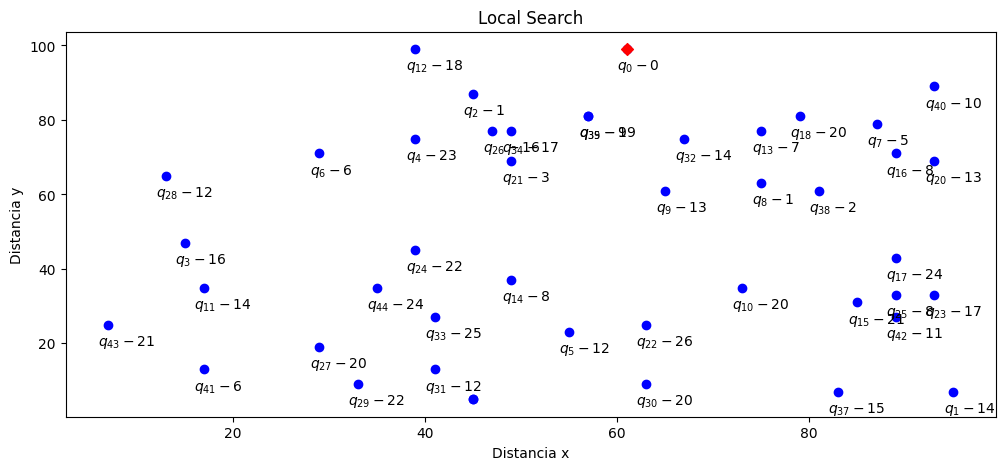

In [41]:
#Grafico
plt.figure(figsize = (12,5))
plt.scatter(x,y, color = 'blue')

#DC
plt.scatter(x[0], y[0], color = 'red', marker = 'D')

#Clientes y demanda
for i in clientes:
    plt.annotate('$q_{%d} - %d$'%(i,q[i]), (x[i]-1, y[i]-5.5))

plt.xlabel("Distancia x")
plt.ylabel("Distancia y")
plt.title("Local Search")

plt.show()

In [42]:
partida_tiempo = time.time()

# Función de Nearest_Neighbor
def Nearest_Neighbor(starting_node, clientes, distancia, capacidad_maxima=capacidad, nodos_visitados=None):
    if nodos_visitados is None:
        nodos_visitados = set()

    NN = [starting_node]
    capacidad_actual = 0
    n = len(clientes)
    nodos_visitados.add(starting_node)

    while len(NN) < n:
        k = NN[-1]
        nn = {(k, j): distancia[(k, j)] for j in clientes if j != k and j not in NN and j not in nodos_visitados}
        if not nn:
            break

        new = min(nn.items(), key=lambda x: x[1])

        # Verificar capacidad antes de agregar el cliente
        if capacidad_actual + q[new[0][1]] <= capacidad_maxima:
            NN.append(new[0][1])
            capacidad_actual += q[new[0][1]]
            nodos_visitados.add(new[0][1])
        else:
            break

    return NN

# Generar 5 rutas distintas, cada una partiendo desde el nodo 0
rutas = []
nodos_visitados_global = set()

for _ in range(vehiculos):
    NN = Nearest_Neighbor(0, clientes, distancia, nodos_visitados=nodos_visitados_global)
    rutas.append(NN)
    nodos_visitados_global.update(NN)

rutas

#Aplicar tabu, local search y a una lista primerop y luego crear otras

[[0, 35, 39, 34, 26, 4, 6],
 [0, 2, 12, 21, 9, 8, 38, 16, 20, 7, 18, 13],
 [0, 32, 40, 17, 25, 23, 42],
 [0, 24, 44, 33, 14, 5],
 [0, 28, 3, 11, 43, 41, 27],
 [0, 10, 15, 22, 30],
 [0, 31, 19, 36, 29, 37]]

In [43]:
def calcular_distancia_ruta(ruta, distancia):
    distancia_total = 0
    for i in range(len(ruta) - 1):
        distancia_total += distancia[(ruta[i], ruta[i + 1])]
    return distancia_total

# Calcular distancias para cada ruta
distancias_rutas = [calcular_distancia_ruta(ruta, distancia) for ruta in rutas]

# Imprimir las distancias de cada ruta
for i, distancia_ruta in enumerate(distancias_rutas):
    print(f"Distancia de la Ruta {i + 1}: {distancia_ruta}")

# Calcular la sumatoria de las distancias de todas las rutas
distancia_total = sum(distancias_rutas)

final_tiempo = time.time()
total_tiempoNN = final_tiempo - partida_tiempo

print(f"\nSuma Total de Distancias: {distancia_total}")
print(f"\nEl tiempo total de ejecucion de NN: {total_tiempoNN}")

Distancia de la Ruta 1: 48.399901690089266
Distancia de la Ruta 2: 142.29367635448673
Distancia de la Ruta 3: 121.65296794756152
Distancia de la Ruta 4: 107.11764324931552
Distancia de la Ruta 5: 132.27710285682525
Distancia de la Ruta 6: 116.5679015270551
Distancia de la Ruta 7: 159.92832678203635

Suma Total de Distancias: 828.2375204073699

El tiempo total de ejecucion de NN: 0.011391401290893555


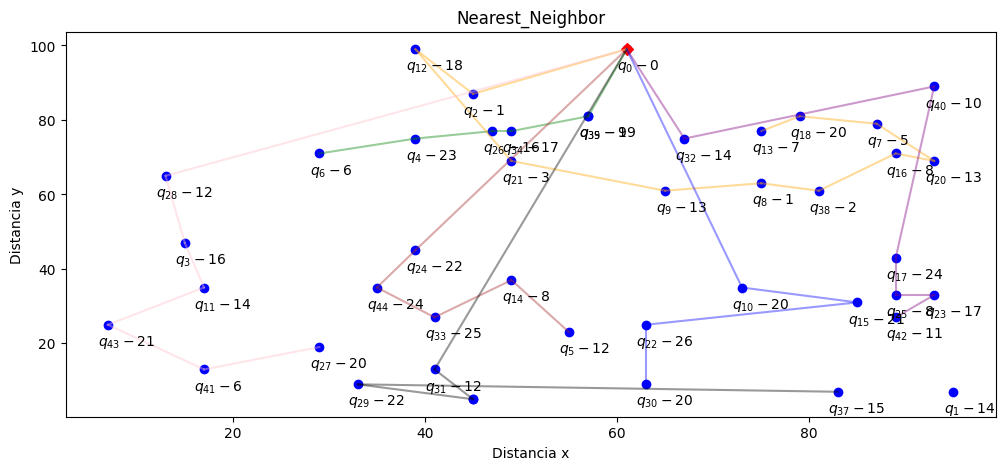

In [44]:
# Grafico
plt.figure(figsize=(12, 5))

# Puntos
plt.scatter(x, y, color='blue')

# DC
plt.scatter(x[0], y[0], color='red', marker='D')

# Clientes y demanda
for i in clientes:
    plt.annotate('$q_{%d} - %d$' % (i, q[i]), (x[i] - 1, y[i] - 5.5))

# Rutas
for r in range(len(rutas)):
    color_ruta = colores_rutas[r % len(colores_rutas)]  # Ciclo de colores para las rutas
    for n in range(len(rutas[r]) - 1):
        i = rutas[r][n]
        j = rutas[r][n + 1]
        plt.plot([x[i], x[j]], [y[i], y[j]], alpha=0.4, color=color_ruta)

plt.xlabel("Distancia x")
plt.ylabel("Distancia y")
plt.title("Nearest_Neighbor")

plt.show()

In [45]:
time_i = time.time()

#Implementacion de Local Seach
def Local_Search(NN,distancia):

    min_cambio = 0

    for i in range(len(NN)-2):
        for j in range(i+2, len(NN)-1):
            
            costo_actual = distancia[(NN[i], NN[i+1])] + distancia[(NN[j], NN[j+1])]
            costo_nuevo = distancia[(NN[i], NN[j])] + distancia[(NN[i+1], NN[j+1])]
            
            cambio = costo_nuevo - costo_actual

            if cambio < min_cambio:
                min_cambio = cambio
                min_i = i
                min_j = j

    if min_cambio < 0:
         NN[min_i +1:min_j+1]=NN[min_i+1:min_j+1][::-1]

    return NN
            

In [46]:
# Inicialización
solucion = NN.copy()
contador = 0

# Ejecución del Algoritmo con Local Search
while True:
    contador += 1
    primera = sum([calcular_distancia_ruta(ruta, distancia) for ruta in rutas])
    
    # Aplicar Local_Search a cada ruta generada
    for i in range(len(rutas)):
        ruta_anterior = rutas[i].copy()
        rutas[i] = Local_Search(rutas[i], distancia)
        dist_actual = calcular_distancia_ruta(ruta_anterior, distancia)
        dist_nueva = calcular_distancia_ruta(rutas[i], distancia)

    ultima = sum([calcular_distancia_ruta(ruta, distancia) for ruta in rutas])
    intercambio = np.abs(ultima - primera)

    # Salir del bucle si no se realizaron cambios en ninguna ruta
    if intercambio == 0:
        break

time_f = time.time()
fin_timeLocal = time_f - time_i

tiempo_total= fin_timeLocal + total_tiempoNN

# Imprimir resultados
print("Solucion", rutas)
print("Distancia Total", sum([calcular_distancia_ruta(ruta, distancia) for ruta in rutas]))
print("Total de Intentos", contador)
print(f"\nTiempo de ejecucion de Local Search: {fin_timeLocal}")
print(f"\nEl tiempo total de NN + Local: {tiempo_total}")


Solucion [[0, 35, 39, 34, 26, 4, 6], [0, 12, 2, 21, 9, 8, 38, 20, 16, 7, 18, 13], [0, 32, 40, 17, 23, 25, 42], [0, 24, 44, 33, 14, 5], [0, 28, 3, 11, 43, 41, 27], [0, 15, 10, 22, 30], [0, 31, 29, 36, 19, 37]]
Distancia Total 801.1603052868704
Total de Intentos 3

Tiempo de ejecucion de Local Search: 0.010824918746948242

El tiempo total de NN + Local: 0.022216320037841797


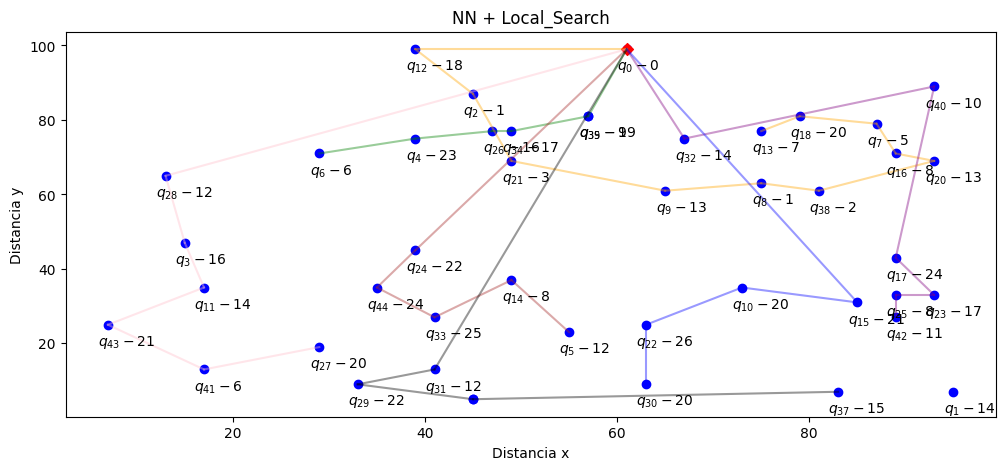

In [47]:
# Grafico
plt.figure(figsize=(12, 5))

# Puntos
plt.scatter(x, y, color='blue')

# DC
plt.scatter(x[0], y[0], color='red', marker='D')

# Clientes y demanda
for i in clientes:
    plt.annotate('$q_{%d} - %d$' % (i, q[i]), (x[i] - 1, y[i] - 5.5))

# Rutas
for r in range(len(rutas)):
    color_ruta = colores_rutas[r % len(colores_rutas)]  # Ciclo de colores para las rutas
    for n in range(len(rutas[r]) - 1):
        i = rutas[r][n]
        j = rutas[r][n + 1]
        plt.plot([x[i], x[j]], [y[i], y[j]], alpha=0.4, color=color_ruta)

plt.xlabel("Distancia x")
plt.ylabel("Distancia y")
plt.title("NN + Local_Search")

plt.show()

In [48]:
#heuristica que genere una solucion aleatoria basado en la restriccion y a esta aplicarle local search